# Task 3: Correlation Between News Sentiment and Stock Movement (All Stocks)

This notebook performs a quantitative analysis to determine the correlation between daily news sentiment and multiple stock price movements.


In [13]:
import os
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')


## Load News Data and Compute Daily Sentiment

- The news dataset must have columns: `date` and `headline`.
- Compute polarity scores for each headline.


In [15]:
# Step 1: Load news dataset
news_path = '../data/newsData/raw_analyst_ratings.csv'

news_df = pd.read_csv(news_path)

# Inspect columns
print("Columns in news dataset:", news_df.columns)

# Keep only required columns
required_cols = ['date', 'headline']
news_df = news_df[required_cols]

# Step 2: Convert date column safely
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')  # Invalid parsing becomes NaT
news_df = news_df.dropna(subset=['date'])  # Remove rows where date couldn't be parsed
news_df['date'] = news_df['date'].dt.date  # Keep only the date part

# Step 3: Sentiment Analysis
from textblob import TextBlob

def get_sentiment(text):
    if pd.isna(text) or not isinstance(text, str):
        return 0.0  # Handle missing or invalid headlines
    return TextBlob(text).sentiment.polarity

news_df['sentiment'] = news_df['headline'].apply(get_sentiment)

# Step 4: Aggregate daily sentiment
daily_sentiment = news_df.groupby('date', as_index=False)['sentiment'].mean()

# Preview
daily_sentiment.head()


Columns in news dataset: Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')


,date,sentiment
0,2011-04-27,0.000000
1,2011-04-28,0.068182
2,2011-04-29,0.166667
3,2011-04-30,0.500000
4,2011-05-01,0.000000


## Loop Through All Stock CSVs and Compute Correlation

- For each stock:
  - Load CSV
  - Compute daily returns
  - Merge with daily sentiment
  - Calculate Pearson correlation coefficient
  - Plot sentiment vs returns


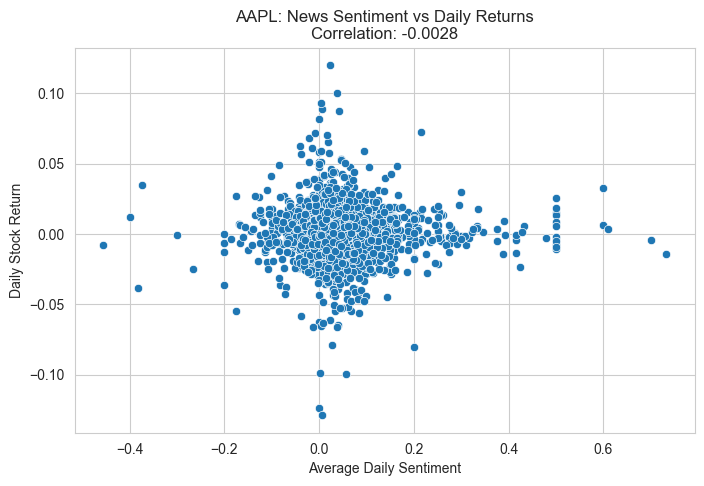

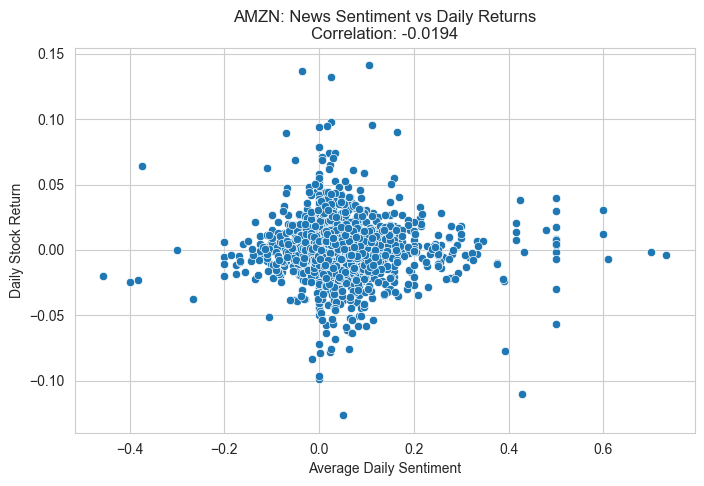

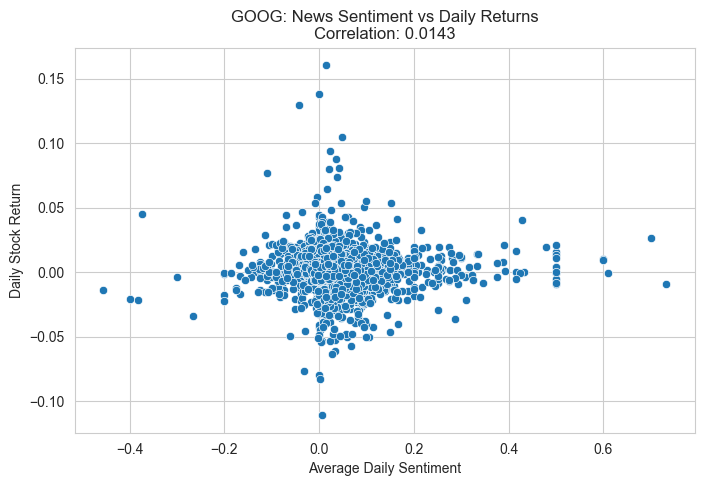

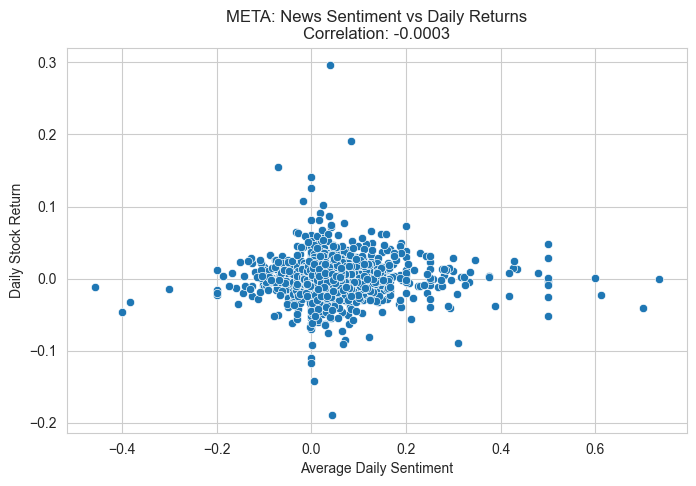

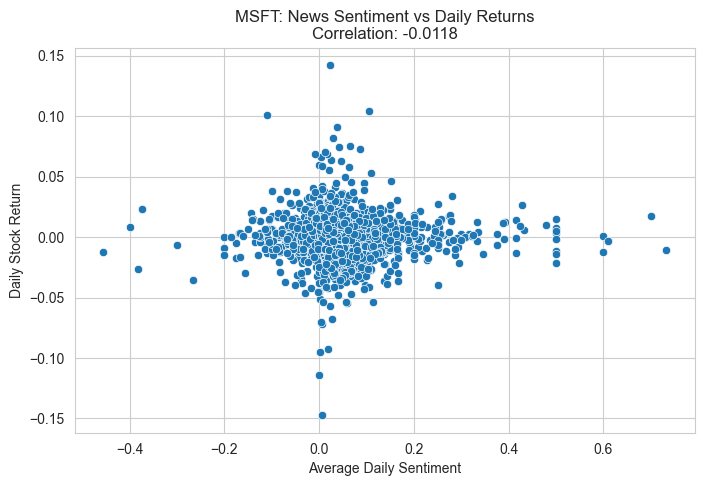

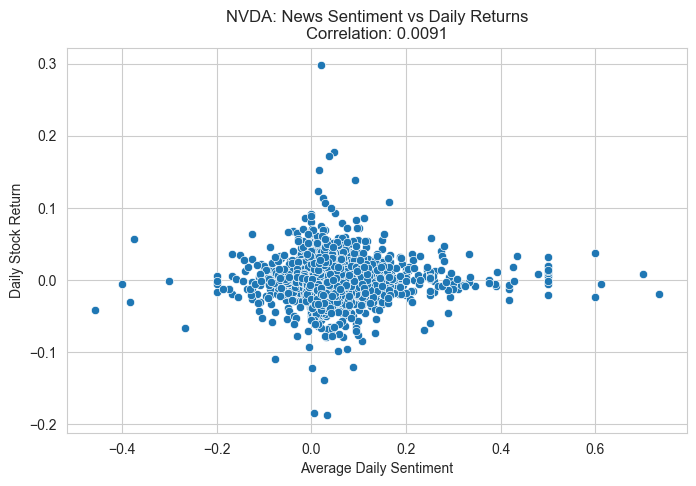

In [11]:
# Folder containing stock CSVs
folder_path = '../data/yfinanceData'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

correlation_results = []

for file in csv_files:
    ticker = file.replace('.csv','')
    stock_path = os.path.join(folder_path, file)
    
    # Load stock CSV
    stock_df = pd.read_csv(stock_path, parse_dates=['Date'], index_col='Date')
    stock_df['date'] = stock_df.index.date
    
    # Compute daily returns
    stock_df['daily_return'] = stock_df['Close'].pct_change()
    stock_df = stock_df.dropna()
    
    # Merge with daily sentiment
    merged_df = pd.merge(stock_df, daily_sentiment, on='date', how='inner')
    
    # Compute correlation
    correlation = merged_df['daily_return'].corr(merged_df['sentiment'])
    correlation_results.append({'Ticker': ticker, 'Correlation': correlation})
    
    # Plot sentiment vs daily returns
    plt.figure(figsize=(8,5))
    sns.scatterplot(x='sentiment', y='daily_return', data=merged_df)
    plt.title(f'{ticker}: News Sentiment vs Daily Returns\nCorrelation: {correlation:.4f}')
    plt.xlabel('Average Daily Sentiment')
    plt.ylabel('Daily Stock Return')
    plt.show()


## Loop Through All Stock CSVs and Prepare Data for Dashboard


In [16]:
# Folder containing stock CSVs
folder_path = '../data/yfinanceData'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

dashboard_data = []

for file in csv_files:
    ticker = file.replace('.csv','')
    stock_path = os.path.join(folder_path, file)
    
    # Load stock CSV
    stock_df = pd.read_csv(stock_path, parse_dates=['Date'], index_col='Date')
    stock_df['date'] = stock_df.index.date
    
    # Compute daily returns
    stock_df['daily_return'] = stock_df['Close'].pct_change()
    stock_df = stock_df.dropna()
    
    # Merge with daily sentiment
    merged_df = pd.merge(stock_df, daily_sentiment, on='date', how='inner')
    
    # Compute correlation
    correlation = merged_df['daily_return'].corr(merged_df['sentiment'])
    
    # Store for dashboard
    dashboard_data.append({'Ticker': ticker, 'data': merged_df, 'correlation': correlation})


## Create Combined Dashboard with Subplots

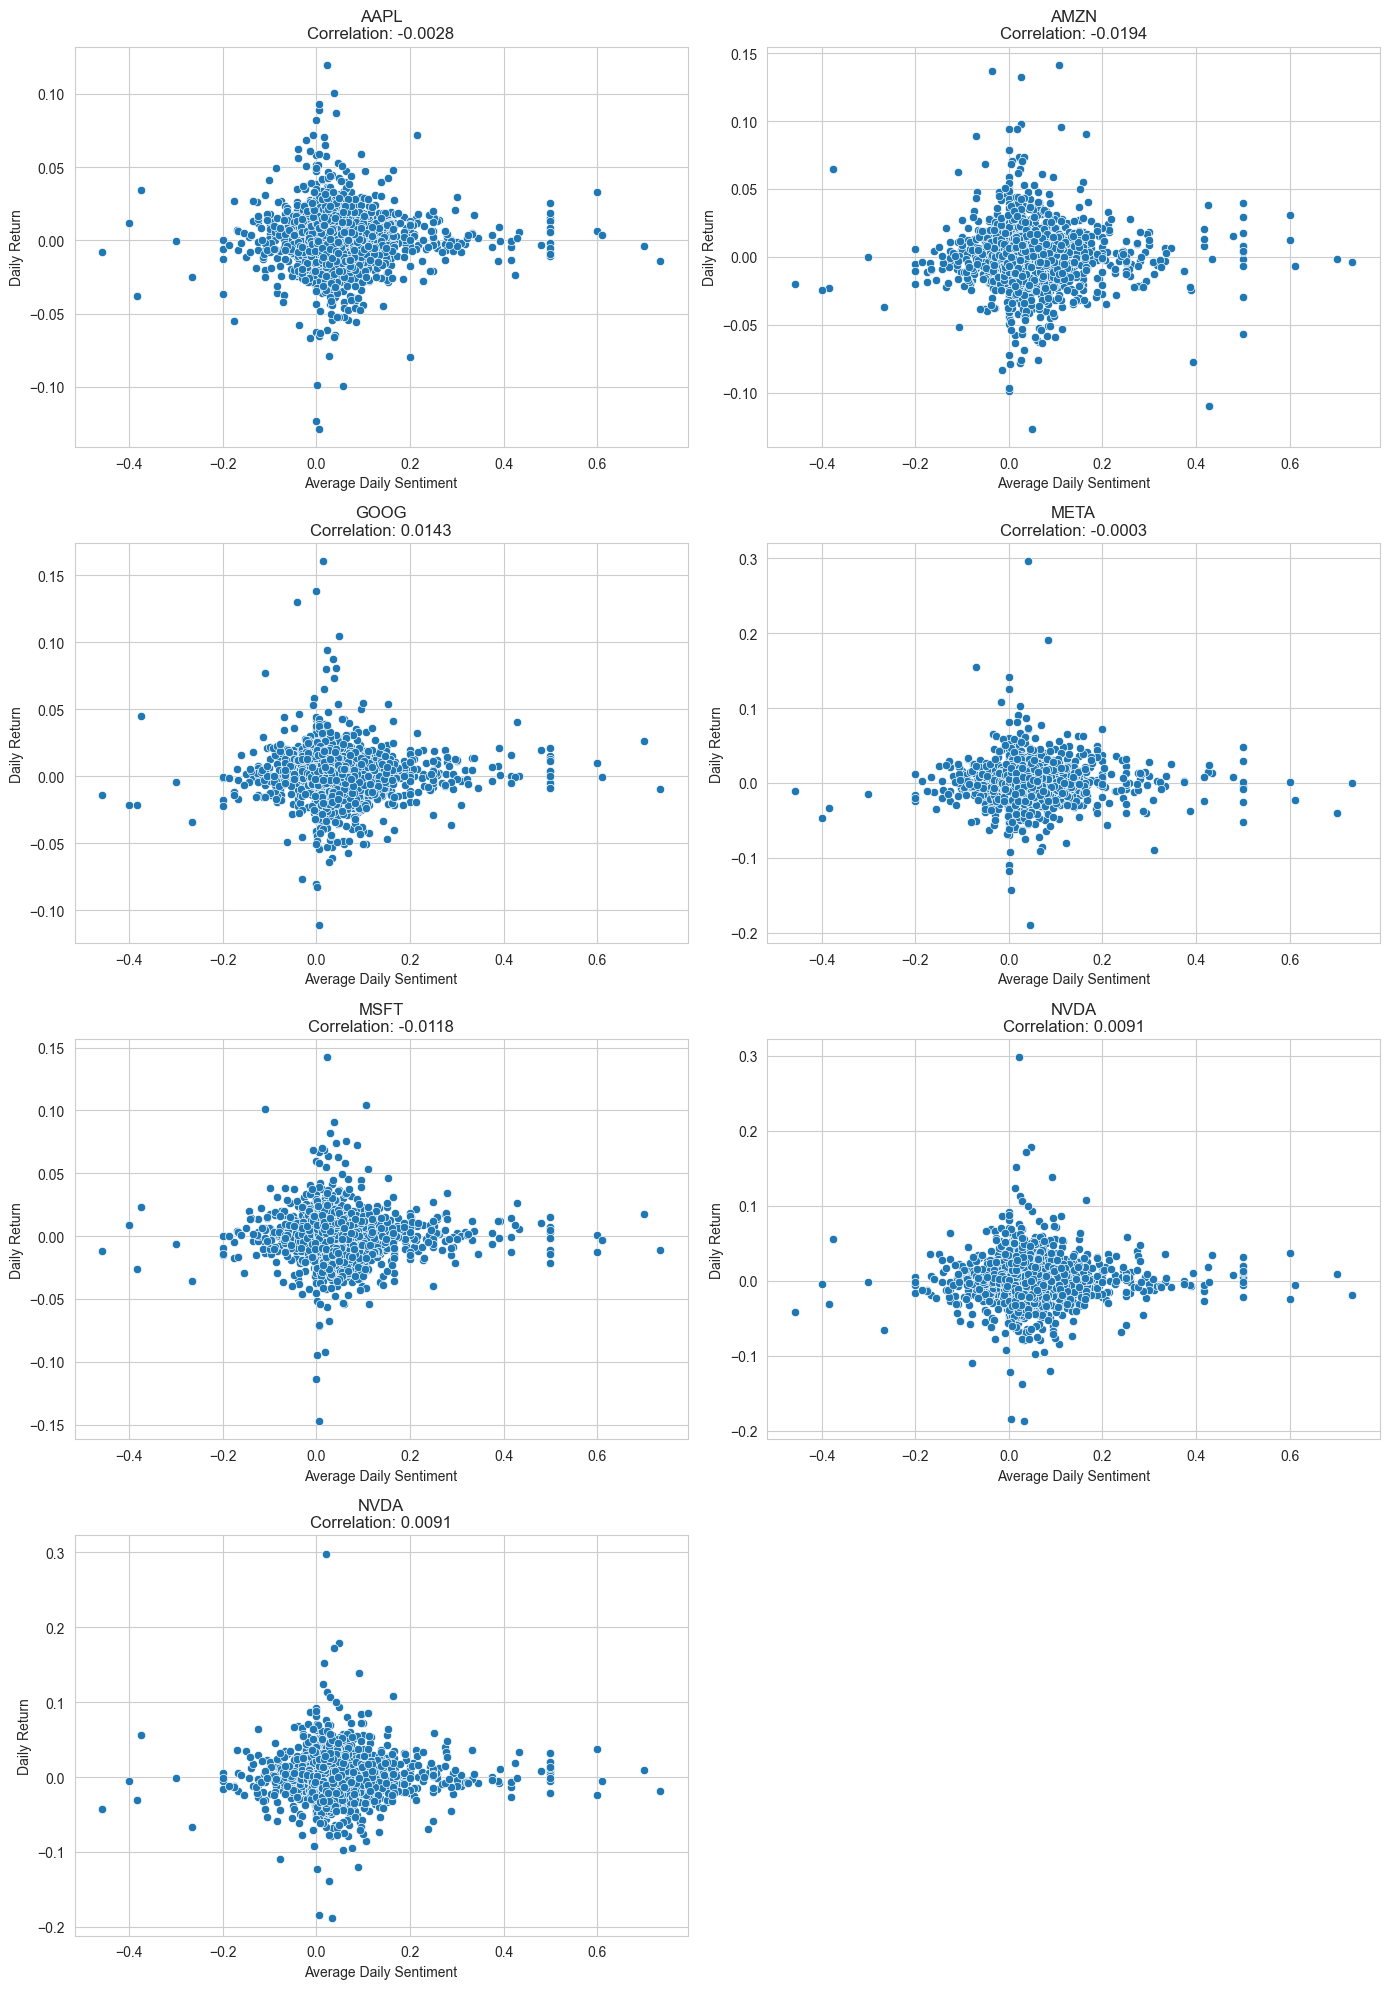

In [17]:
# Store for dashboard
dashboard_data.append({'Ticker': ticker, 'data': merged_df, 'correlation': correlation})

num_stocks = len(dashboard_data)
cols = 2
rows = (num_stocks + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 5*rows))
axes = axes.flatten()

for i, stock_info in enumerate(dashboard_data):
    df = stock_info['data']
    ticker = stock_info['Ticker']
    corr = stock_info['correlation']
    
    sns.scatterplot(x='sentiment', y='daily_return', data=df, ax=axes[i])
    axes[i].set_title(f'{ticker}\nCorrelation: {corr:.4f}')
    axes[i].set_xlabel('Average Daily Sentiment')
    axes[i].set_ylabel('Daily Return')

# Hide unused subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Summary Table of Correlations

- Shows correlation coefficient between average daily sentiment and daily returns for each stock.


In [ ]:
correlation_df = pd.DataFrame(correlation_results)
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)
correlation_df.reset_index(drop=True, inplace=True)
correlation_df


## Summary

- All stock CSVs in `yfinanceData` are processed automatically.
- Daily sentiment scores are computed from news headlines.
- Daily stock returns are calculated and merged with sentiment data.
- Pearson correlation is calculated for each stock.
- Scatter plots visualize sentiment vs stock returns for all stocks.
- A single combined dashboard displays all stocks in **subplots** for easy comparison.
- Correlation summary table provides an at-a-glance view of sentiment influence across multiple stocks.
